In [1]:
# Install dependencies (if not already installed)
# !pip install torch transformers pandas scikit-learn matplotlib

# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/balanced-emo-dataset/ai_emotion_balanced.csv')

# Display dataset info and sample rows
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89754 entries, 0 to 89753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    89754 non-null  object
 1   label   89754 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB
None
                                                text  label
0                      i feel like a terrible parent      0
1  i was younger i used to feel dismayed about th...      0
2  i feel for cu o line coach ed argast who i bel...      0
3  i truly do hope this helps somebody else who k...      0
4  i feel like i would be very ungrateful if i fo...      0


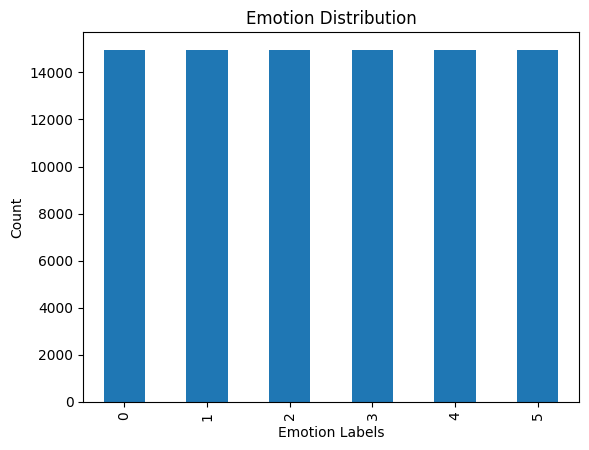

In [3]:
# Define emotion labels and mapping
label2int = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Plot label distribution
df['label'].value_counts().plot(kind='bar')
plt.title('Emotion Distribution')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.show()

In [4]:
# Stratified split into train, validation, and test sets
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

# Display dataset sizes
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 62827
Validation set size: 13463
Test set size: 13464


In [5]:
# Compute class weights
train_labels = df_train['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {label: weight for label, weight in zip(np.unique(train_labels), class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9999204227145404, 1: 1.0000159169770477, 2: 1.0000159169770477, 3: 1.0000159169770477, 4: 1.0000159169770477, 5: 1.0000159169770477}


In [6]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Test the tokenizer
sample_text = "This is a sample sentence for tokenization."
tokenized_output = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokenized_output)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'input_ids': [0, 713, 16, 10, 7728, 3645, 13, 19233, 1938, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Set device: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend for training.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA backend for training.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

Using CUDA backend for training.


In [8]:
#Define a custom dataset class to handle tokenized text and labels.
'''Text and Labels: Extract text and label columns from the DataFrame.
Tokenization: Each sample is tokenized using tokenizer.
PyTorch Tensors: Convert inputs and labels to PyTorch tensors.'''

import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
            'labels': torch.tensor(label, dtype=torch.long).to(device)
        }

    def __len__(self):
        return len(self.labels)


# Create dataset objects
train_dataset = EmotionDataset(df_train, tokenizer)
val_dataset = EmotionDataset(df_val, tokenizer)
test_dataset = EmotionDataset(df_test, tokenizer)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Training samples: 62827, Validation samples: 13463, Test samples: 13464


In [9]:
#Mish Activation Function

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [10]:
'''#Custom Emotional Classification Model

class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        # Initialize weights
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)'''

class EmoModelWithAttention(torch.nn.Module):
    def __init__(self, base_model, n_classes):
        super().__init__()
        self.base_model = base_model
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, 768),
            Mish(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, n_classes)
        )
        self.attention_weights = torch.nn.Linear(768, 1)  # Attention score per token

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Compute attention scores
        attention_scores = self.attention_weights(hidden_states).squeeze(-1)
        attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Weighted average of token embeddings
        pooled_output = torch.sum(hidden_states * attention_weights.unsqueeze(-1), dim=1)
        
        return self.classifier(pooled_output)


In [11]:
#Initialise the model

from transformers import AutoModel

# Load the pre-trained DistilRoBERTa model
base_model = AutoModel.from_pretrained('roberta-base')

# Number of emotion classes
n_classes = df['label'].nunique()

# Initialize the model
model = EmoModelWithAttention(base_model=base_model, n_classes=n_classes)
model.to(device)

print(model)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EmoModelWithAttention(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [12]:
#Prepare PyTorch DataLoaders to efficiently load data during training and evaluation:

from torch.utils.data import DataLoader

# Define batch size
BATCH_SIZE = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Verify a batch from the DataLoader
batch = next(iter(train_loader))
print(batch['input_ids'].shape)  # Expected: [16, 128]
print(batch['attention_mask'].shape)  # Expected: [16, 128]
print(batch['labels'].shape)  # Expected: [16]

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [13]:
# Print a sample batch
for batch in train_loader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention Mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
    break

Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


In [14]:
#class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(device)

# Define loss function with class weights
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [15]:
# Evaluation Metrics with Class-Specific Breakdown
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(predictions, labels):
    """
    Compute accuracy, precision, recall, F1-score, and a classification report.
    Args:
        predictions (Tensor): 1D tensor of predicted class indices.
        labels (Tensor): 1D tensor of true class indices.
    """
    # Ensure tensors are on CPU
    predictions = predictions.cpu()
    labels = labels.cpu()
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    class_report = classification_report(labels, predictions, target_names=emotions, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': class_report
    }


In [16]:
# Training Loop with Metrics Display
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        val_loss, metrics = evaluate_model(model, val_loader, criterion)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
        print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1_score']:.4f}")
        print("Classification Report:\n", metrics['classification_report'])


In [17]:
# Validation Loop with Class-Specific Metrics
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)  # Get predicted class indices
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    avg_loss = total_loss / len(val_loader)
    
    # Combine all predictions and labels into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    metrics = compute_metrics(all_preds, all_labels)
    return avg_loss, metrics


In [18]:
print("Model device:", next(model.parameters()).device)
batch = next(iter(train_loader))
print("Input IDs device:", batch['input_ids'].device)
print("Attention Mask device:", batch['attention_mask'].device)
print("Labels device:", batch['labels'].device)

# Now, run the training loop:

# Number of epochs
EPOCHS = 5

# Move model to GPU/MPS if available
model.to(device)

# Start training
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS)# Save the model

Model device: cuda:0
Input IDs device: cuda:0
Attention Mask device: cuda:0
Labels device: cuda:0


Epoch 1: 100%|██████████| 3927/3927 [24:43<00:00,  2.65it/s]


Epoch 1: Train Loss = 0.2790, Val Loss = 0.1611
Accuracy: 0.9411, Precision: 0.9427, Recall: 0.9411, F1-Score: 0.9409
Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.94      0.96      2243
         joy       0.98      0.90      0.94      2244
        love       0.93      0.97      0.95      2244
       anger       0.91      0.97      0.94      2244
        fear       0.95      0.87      0.91      2244
    surprise       0.91      0.99      0.95      2244

    accuracy                           0.94     13463
   macro avg       0.94      0.94      0.94     13463
weighted avg       0.94      0.94      0.94     13463



Epoch 2: 100%|██████████| 3927/3927 [23:41<00:00,  2.76it/s]


Epoch 2: Train Loss = 0.1621, Val Loss = 0.1718
Accuracy: 0.9386, Precision: 0.9400, Recall: 0.9386, F1-Score: 0.9383
Classification Report:
               precision    recall  f1-score   support

     sadness       0.93      0.96      0.95      2243
         joy       0.99      0.89      0.94      2244
        love       0.92      0.98      0.95      2244
       anger       0.94      0.92      0.93      2244
        fear       0.94      0.88      0.91      2244
    surprise       0.91      0.99      0.95      2244

    accuracy                           0.94     13463
   macro avg       0.94      0.94      0.94     13463
weighted avg       0.94      0.94      0.94     13463



Epoch 3: 100%|██████████| 3927/3927 [23:44<00:00,  2.76it/s]


Epoch 3: Train Loss = 0.1541, Val Loss = 0.1377
Accuracy: 0.9473, Precision: 0.9490, Recall: 0.9473, F1-Score: 0.9472
Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.94      0.97      2243
         joy       0.99      0.91      0.95      2244
        love       0.93      0.99      0.96      2244
       anger       0.93      0.95      0.94      2244
        fear       0.94      0.90      0.92      2244
    surprise       0.91      1.00      0.95      2244

    accuracy                           0.95     13463
   macro avg       0.95      0.95      0.95     13463
weighted avg       0.95      0.95      0.95     13463



Epoch 4: 100%|██████████| 3927/3927 [23:40<00:00,  2.76it/s]


Epoch 4: Train Loss = 0.1438, Val Loss = 0.1597
Accuracy: 0.9439, Precision: 0.9453, Recall: 0.9439, F1-Score: 0.9438
Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.94      0.96      2243
         joy       0.99      0.90      0.94      2244
        love       0.93      0.98      0.96      2244
       anger       0.94      0.94      0.94      2244
        fear       0.92      0.91      0.91      2244
    surprise       0.92      0.99      0.95      2244

    accuracy                           0.94     13463
   macro avg       0.95      0.94      0.94     13463
weighted avg       0.95      0.94      0.94     13463



Epoch 5: 100%|██████████| 3927/3927 [23:41<00:00,  2.76it/s]


Epoch 5: Train Loss = 0.1362, Val Loss = 0.1492
Accuracy: 0.9447, Precision: 0.9472, Recall: 0.9447, F1-Score: 0.9442
Classification Report:
               precision    recall  f1-score   support

     sadness       0.97      0.95      0.96      2243
         joy       0.99      0.90      0.94      2244
        love       0.93      0.99      0.96      2244
       anger       0.90      0.98      0.94      2244
        fear       0.97      0.86      0.91      2244
    surprise       0.91      1.00      0.95      2244

    accuracy                           0.94     13463
   macro avg       0.95      0.94      0.94     13463
weighted avg       0.95      0.94      0.94     13463



In [19]:
# Save the model
torch.save(model.state_dict(), 'ai_emotion_classification_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [20]:
# Evaluate on Test Data with Class-Specific Metrics

test_loss, test_metrics = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1_score']:.4f}")
print("Classification Report:\n", test_metrics['classification_report'])

Test Loss: 0.1440
Test Accuracy: 0.9436
Precision: 0.9462
Recall: 0.9436
F1-Score: 0.9433
Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.94      0.96      2244
         joy       0.99      0.89      0.94      2244
        love       0.92      0.98      0.95      2244
       anger       0.91      0.98      0.94      2244
        fear       0.96      0.87      0.91      2244
    surprise       0.91      1.00      0.95      2244

    accuracy                           0.94     13464
   macro avg       0.95      0.94      0.94     13464
weighted avg       0.95      0.94      0.94     13464



In [21]:
#Inference Example 

def predict_emotion(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        prediction = torch.argmax(outputs, dim=1).cpu().item()
    
    return prediction

# Example prediction
sample_text = "I'm feeling really afraid today!"
emotion = predict_emotion(sample_text, model, tokenizer)
print(f"Predicted Emotion: {emotion}")

Predicted Emotion: 4
